In [129]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import cv2
from pathlib import Path
from scipy.interpolate import interp1d
import carla
from scipy.spatial.transform import Rotation as R
import pymap3d as pm

In [130]:
carla_path = Path("./output/pure_carla/carla2k19/Chunk_1/batch1/1")
comma_path = Path("../../datasets/comma2k19/Chunk_1/b0c9d2329ad1606b|2018-07-27--06-50-48/14")


# Comparing processing of positions and orientations

Functions to convert between carla positions and orientations and the comma2k way.

In [131]:
def euler_to_quat(roll, pitch, yaw, deg: bool=False):
    rot = R.from_euler("xyz", (roll, pitch, yaw), degrees=deg)
    # This returns the quaternion on the [x, y, z, w] format
    quat = rot.as_quat()
    x = quat[0]
    y = quat[1]
    z = quat[2]
    w = quat[3]
    return np.array([w, x, y, z])

In [132]:
# HERE: The one currently in use
def euler_to_quaternion2(map: carla.Map, location: carla.Location, rotation: carla.Rotation):
    # alt0 = origin_geolocation.altitude

    # I know this rot matrix works in the original implementation
    # Construct rotation matrix from ECEF to ENU frames
    # https://gssc.esa.int/navipedia/index.php/Transformations_between_ECEF_and_ENU_coordinates
    # r = R.from_matrix([
    #     [-np.sin(lon0),  -np.cos(lon0)*np.sin(lat0),   np.cos(lon0)*np.cos(lat0)],
    #     [np.cos(lon0),   -np.sin(lon0)*np.sin(lat0),   np.sin(lon0)*np.cos(lat0)],
    #     [0,               np.cos(lat0),                np.sin(lat0)             ]]).inv()

    # I think we should remove .inv() because I think original example was from ECEF to ENU
    # https://carla.readthedocs.io/en/latest/python_api/#carlarotation
    # https://se.mathworks.com/help/uav/ug/coordinate-systems-for-unreal-engine-simulation-in-uav-toolbox.html
    # In carla
    # pitch is right-handed rotation around the y-axis
    # yaw is rotation around the z-axis
    # roll is rotation around the x-axis
    # To adjust for the difference in coordinate systems, we need to negate pitch and yaw
    # Adding 180 to convert from values [-180, 180] to [0, 360]
    x = np.radians(rotation.roll)
    # NOTE: Changing x to negative does nothing
    y = -(np.radians(rotation.pitch) + np.pi)
    z = -(np.radians(rotation.yaw) + np.pi)
    
    # x = np.radians(rotation.roll)
    # y = np.radians(rotation.pitch)
    # z = np.radians(rotation.yaw)
    carla_rot = R.from_euler("xyz", (x, y, z), degrees=False)
    # r_z_carla_to_enu = R.from_matrix([
    #     [np.cos(z), -np.sin(z), 0],
    #     [np.sin(z), np.cos(z), 0],
    #     [0, 0, 1]
    # ])

    # r_y_neg_carla_to_enu = R.from_matrix([
    #         [np.cos(-y), 0, np.sin(-y)],
    #         [0, 1, 0],
    #         [-np.sin(-y), 0, np.cos(-y)]
    #     ])

    # r_x_carla_to_enu = R.from_matrix([
    #         [1, 0, 0],
    #         [0, np.cos(x), -np.sin(x)],
    #         [0, np.sin(x), np.cos(x)]
    #     ])

    # Additional rotation matrix to align Unreal Engine's coordinate system with ENU
    # To make them compatible, we force the Unreal coordinate space to be aligned with the ENU space
    # Then x and y is swapped (but have the same rotation sign) and z is negated
    # R_align = R.from_matrix([
    #     [0, 1, 0],
    #     [1, 0, 0],
    #     [0, 0, -1]
    # ])


    # r_carla_to_ecef =  R_align #* r_z_carla_to_enu * r_y_neg_carla_to_enu * r_x_carla_to_enu
    # enu_rot = r_carla_to_ecef * carla_rot
    enu_rot = carla_rot
    # Rotate the rotation to ENU
    

    # x, y = y, x
    # z = -z
    # We have that in CARLA
    # yaw [-180, 180]  YES
    # roll [-180, 180] ALL VALUES ARE AROUND 0
    # pitch [-90, 90] YES
    
    # NEW HERE  
    # OLD HERE
    origin_geolocation = map.transform_to_geolocation(carla.Location(0, 0, 0)) 
    # print("origin_geolocation = ", origin_geolocation.latitude, origin_geolocation.longitude, origin_geolocation.altitude)
    lat0 = np.radians(origin_geolocation.latitude)
    lon0 = np.radians(origin_geolocation.longitude)
    r_enu_to_ecef = R.from_matrix(
        [
            [-np.sin(lon0), -np.cos(lon0) * np.sin(lat0), np.cos(lon0) * np.cos(lat0)],
            [np.cos(lon0), -np.sin(lon0) * np.sin(lat0), np.sin(lon0) * np.cos(lat0)],
            [0, np.cos(lat0), np.sin(lat0)],
        ]
    )

    # enu_rot = R.from_euler("xyz", (x, y, z), degrees=False)
    ecef_rot = r_enu_to_ecef * enu_rot
    # This returns the quaternion on the [x, y, z, w] format
    ecef_orientation = ecef_rot.as_quat()
    x = ecef_orientation[0]
    y = ecef_orientation[1]
    z = ecef_orientation[2]
    w = ecef_orientation[3]

    # print(f"{ecef_orientation = }")
    return np.array([w, x, y, z])

# HERE: The one currently in use
def carla_location_to_ecef(map: carla.Map, location: carla.Location):
    # I want to check if this finds the origin
    origin_geolocation = map.transform_to_geolocation(carla.Location(0, 0, 0)) 
    # geolocation = map.transform_to_geolocation(location)
    # https://docs.unrealengine.com/4.27/en-US/BuildingWorlds/Georeferencing/
    e_enu = location.x  # meters
    n_enu = -location.y  # Negate y to convert from right-handed to left-handed coordinate system
    # n_enu = location.y
    u_enu = location.z

    x, y, z = pm.enu2ecef(
        e_enu,
        n_enu, 
        u_enu,
        np.radians(origin_geolocation.latitude),
        np.radians(origin_geolocation.longitude),
        origin_geolocation.altitude,
        deg=False,
    )
    # latitude = geolocation.latitude
    # longitude = geolocation.longitude
    # altitude = geolocation.altitude

    return np.array([x, y, z])

Functions used to process positions and orientations in the comma2k dataset to plot the trajectory of the vehicle.

In [133]:
def quat2rot(quats):
  quats = np.array(quats)
  input_shape = quats.shape
  quats = np.atleast_2d(quats)
  Rs = np.zeros((quats.shape[0], 3, 3))
  q0 = quats[:, 0]
  q1 = quats[:, 1]
  q2 = quats[:, 2]
  q3 = quats[:, 3]
  Rs[:, 0, 0] = q0 * q0 + q1 * q1 - q2 * q2 - q3 * q3
  Rs[:, 0, 1] = 2 * (q1 * q2 - q0 * q3)
  Rs[:, 0, 2] = 2 * (q0 * q2 + q1 * q3)
  Rs[:, 1, 0] = 2 * (q1 * q2 + q0 * q3)
  Rs[:, 1, 1] = q0 * q0 - q1 * q1 + q2 * q2 - q3 * q3
  Rs[:, 1, 2] = 2 * (q2 * q3 - q0 * q1)
  Rs[:, 2, 0] = 2 * (q1 * q3 - q0 * q2)
  Rs[:, 2, 1] = 2 * (q0 * q1 + q2 * q3)
  Rs[:, 2, 2] = q0 * q0 - q1 * q1 - q2 * q2 + q3 * q3

  if len(input_shape) < 2:
    return Rs[0]
  else:
    return Rs


def process_pose(frame_positions_in, frame_orientations_in, seq_length):
    num_pts = 10 * 20  # 10 s * 20 Hz = 200 frames DONT CHANGE
    fix_seq_length = seq_length - num_pts - 1  # Is 800 when not in demo
    seq_start_idx = seq_length - (fix_seq_length + num_pts)
    seq_start_idx = np.random.randint(1, seq_start_idx + 1)
    seq_end_idx = seq_start_idx + fix_seq_length
    frame_positions = frame_positions_in[seq_start_idx : seq_end_idx + num_pts]
    frame_orientations = frame_orientations_in[seq_start_idx : seq_end_idx + num_pts]
    t_anchors = np.array(
            (
                0.0,
                0.00976562,
                0.0390625,
                0.08789062,
                0.15625,
                0.24414062,
                0.3515625,
                0.47851562,
                0.625,
                0.79101562,
                0.9765625,
                1.18164062,
                1.40625,
                1.65039062,
                1.9140625,
                2.19726562,
                2.5,
                2.82226562,
                3.1640625,
                3.52539062,
                3.90625,
                4.30664062,
                4.7265625,
                5.16601562,
                5.625,
                6.10351562,
                6.6015625,
                7.11914062,
                7.65625,
                8.21289062,
                8.7890625,
                9.38476562,
                10.0,
            )
        )
    t_idx = np.linspace(0, 10, num=num_pts)

    future_poses = []
    for i in range(fix_seq_length):
        # It is using the current rotation as reference
        ecef_from_local = quat2rot(frame_orientations[i])
        local_from_ecef = ecef_from_local.T
        print(f"{local_from_ecef = }")
        frame_positions_local = np.einsum(
            "ij,kj->ki", local_from_ecef, frame_positions - frame_positions[i]  # remove local_from_ecef[i]
        ).astype(np.float32)

        # Time-Anchor like OpenPilot
        fs = [
            interp1d(t_idx, frame_positions_local[i : i + num_pts, j])
            for j in range(3)
        ]
        interp_positions = [fs[j](t_anchors)[:, None] for j in range(3)]
        interp_positions = np.concatenate(interp_positions, axis=1)

        future_poses.append(interp_positions)
    future_poses = torch.tensor(np.array(future_poses), dtype=torch.float32)
    return future_poses

In [134]:
seq_length = 1200

In [135]:
def plot_trajectory(poses, index=0):
    poses = poses[index]
    plot_args = dict(label="gt", alpha=1, linewidth=2)
    plt.plot(poses[:, 1], poses[:, 0], "o-", **plot_args)
    plt.xlim((-30, 30))
    plt.ylim((-100, 200))
    plt.show()

In [136]:
def load_video_images(path: str):
    frames = []
    video = cv2.VideoCapture(path)
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        frames.append(frame)
    return frames



# CARLA

In [137]:
# These are original carla positions and orientations in their own coordinate system
plt.ioff()
carla_positions_np = np.load(carla_path / "global_pose/frame_positions")
carla_orientations_np = np.load(carla_path / "global_pose/frame_orientations")
carla_positions = [carla.Location(pos[0], pos[1], pos[2]) for pos in carla_positions_np]
carla_orientations = [carla.Rotation(pos[0], pos[1], pos[2]) for pos in carla_orientations_np]

def load_carla_map():
    with open("/home/ulrikro/code/Carla2/CARLA_0.9.15/CarlaUE4/Content/Carla/Maps/OpenDrive/Town01.xodr", "r") as file:
        data = file.read()
        return carla.Map("Town01", data)

carla_map = load_carla_map()
carla_ecef_pos = np.array([carla_location_to_ecef(carla_map, pos) for pos in carla_positions])
carla_ecef_rot = np.array([euler_to_quaternion2(carla_map, pos, rot) for pos, rot in zip(carla_positions, carla_orientations)])
print("carla_ecef_pos.shape", carla_ecef_pos.shape)
print("carla_ecef_rot.shape", carla_ecef_rot.shape)

carla_ecef_pos.shape (1200, 3)
carla_ecef_rot.shape (1200, 4)


In [138]:
df = pd.DataFrame(carla_orientations_np, columns=["pitch", "yaw", "roll"])
df.describe()

,pitch,yaw,roll
count,1200.000000,1200.000000,1200.000000
mean,-0.001700,-128.505952,-0.009996
std,0.026147,76.335776,0.083012
min,-0.216947,-179.984848,-0.432556
25%,-0.005042,-179.951508,-0.000061
50%,-0.000061,-179.749481,-0.000061
75%,0.000096,-89.957579,-0.000061
max,0.098225,179.932022,0.346678


In [139]:
np.set_printoptions(suppress=True, precision=5)
carla_ecef_rot[0:5]

array([[-0.01289, -0.70638,  0.01279,  0.7076 ],
       [-0.0006 , -0.70712,  0.00097,  0.7071 ],
       [-0.0012 , -0.70712,  0.00193,  0.70709],
       [-0.0018 , -0.70713,  0.0029 ,  0.70707],
       [-0.00239, -0.70714,  0.00386,  0.70706]])

In [140]:
# Process carla poses
carla_future_poses = process_pose(carla_ecef_pos, carla_ecef_rot, seq_length)
carla_future_poses.size()

local_from_ecef = array([[ 0.00003, -0.00221, -1.     ],
       [-0.00052, -1.     ,  0.00221],
       [-1.     ,  0.00052, -0.00003]])
local_from_ecef = array([[ 0.00005, -0.00443, -0.99999],
       [-0.00104, -0.99999,  0.00443],
       [-1.     ,  0.00104, -0.00006]])
local_from_ecef = array([[ 0.00008, -0.00664, -0.99998],
       [-0.00156, -0.99998,  0.00664],
       [-1.     ,  0.00156, -0.00009]])
local_from_ecef = array([[ 0.00011, -0.00885, -0.99996],
       [-0.00208, -0.99996,  0.00885],
       [-1.     ,  0.00208, -0.00013]])
local_from_ecef = array([[-0.00028, -0.0097 , -0.99995],
       [-0.0007 , -0.99995,  0.0097 ],
       [-1.     ,  0.0007 ,  0.00028]])
local_from_ecef = array([[-0.00081, -0.00952, -0.99995],
       [-0.00033, -0.99995,  0.00952],
       [-1.     ,  0.00033,  0.0008 ]])
local_from_ecef = array([[-0.00116, -0.00931, -0.99996],
       [-0.00022, -0.99996,  0.00931],
       [-1.     ,  0.00023,  0.00116]])
local_from_ecef = array([[-0.00137, -0.00912, -0

local_from_ecef = array([[ 0.00012, -0.11714,  0.99312],
       [ 0.00404,  0.99311,  0.11714],
       [-0.99999,  0.004  ,  0.0006 ]])
local_from_ecef = array([[ 0.00015, -0.08953,  0.99598],
       [ 0.00356,  0.99598,  0.08953],
       [-0.99999,  0.00354,  0.00047]])
local_from_ecef = array([[ 0.00018, -0.06574,  0.99784],
       [ 0.00316,  0.99783,  0.06574],
       [-1.     ,  0.00314,  0.00038]])
local_from_ecef = array([[ 0.00019, -0.04534,  0.99897],
       [ 0.00278,  0.99897,  0.04534],
       [-1.     ,  0.00277,  0.00032]])
local_from_ecef = array([[ 0.00019, -0.02761,  0.99962],
       [ 0.00246,  0.99962,  0.02761],
       [-1.     ,  0.00246,  0.00025]])
local_from_ecef = array([[ 0.00016, -0.01494,  0.99989],
       [ 0.00189,  0.99989,  0.01494],
       [-1.     ,  0.00188,  0.00019]])
local_from_ecef = array([[ 0.00013, -0.00638,  0.99998],
       [ 0.00147,  0.99998,  0.00638],
       [-1.     ,  0.00147,  0.00014]])
local_from_ecef = array([[ 0.00009,  0.00003,  1

torch.Size([999, 33, 3])

Rotation seem to be very small values in the CARLA dataset... Why?

In [166]:
carla_index = 900  # 30
carla_future_poses[carla_index][[0, 1, 5, 10, 15, 20]].numpy()

array([[ 0.     ,  0.     ,  0.     ],
       [ 0.07839,  0.     ,  0.     ],
       [ 1.95933,  0.00009, -0.     ],
       [ 7.83705,  0.00043, -0.00001],
       [17.63329,  0.00095, -0.00003],
       [31.11036,  0.00424, -0.00013]], dtype=float32)

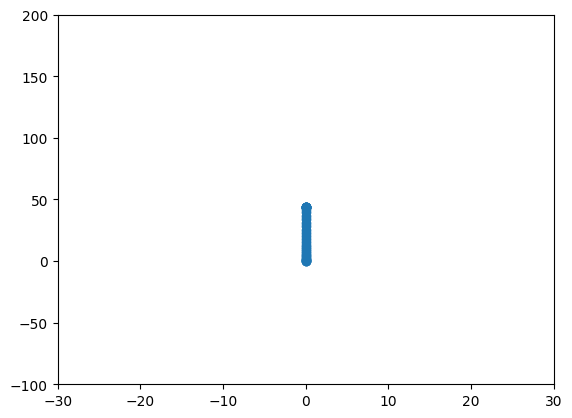

In [167]:
plot_trajectory(carla_future_poses, index=carla_index)

In [143]:
carla_imgs = load_video_images((carla_path / "video.hevc").as_posix())
carla_frame = Image.fromarray(carla_imgs[carla_index][:, :, ::-1])
plt.imshow(np.array(carla_frame))



Here we can see that the coordinates suggests a left turn, but the picture suggests a right turn.

# comma2k19

In [144]:
comma_positions = np.load(comma_path / "global_pose/frame_positions")
# The comma rotations should be global rotations
comma_orientations = np.load(comma_path / "global_pose/frame_orientations")
print("comma_positions.shape", comma_positions.shape)
print("comma_orientations.shape", comma_orientations.shape)


comma_positions.shape (1200, 3)
comma_orientations.shape (1200, 4)


In [145]:
comma_euler = R.from_quat([item[[3, 0, 1, 2]] for item in comma_orientations]).as_euler("xyz", degrees=True)
comma_df = pd.DataFrame(comma_euler, columns=["roll", "pitch", "yaw"])
comma_df.describe()

,roll,pitch,yaw
count,1200.000000,1200.000000,1200.000000
mean,-3.626729,-49.779652,124.949860
std,1.009372,1.640386,1.366005
min,-7.883675,-53.032832,122.877130
25%,-3.888426,-50.576969,123.941255
50%,-3.443872,-49.362037,124.909263
75%,-3.067703,-48.613075,125.460145
max,-1.706521,-47.308963,130.852985


In [146]:
comma_orientations[0:5]

array([[ 0.23005, -0.81196, -0.40265, -0.35449],
       [ 0.23055, -0.81165, -0.40324, -0.35421],
       [ 0.23093, -0.8114 , -0.40382, -0.35389],
       [ 0.23113, -0.81121, -0.40434, -0.35359],
       [ 0.23108, -0.81113, -0.40474, -0.35336]])

In [147]:
# Process comma2k19 poses
comma_future_poses = process_pose(comma_positions, comma_orientations, seq_length)
comma_future_poses.size()

local_from_ecef = array([[ 0.42386,  0.49126,  0.76092],
       [ 0.81791, -0.56848, -0.08859],
       [ 0.38905,  0.65992, -0.64276]])
local_from_ecef = array([[ 0.42338,  0.49187,  0.76079],
       [ 0.81876, -0.56721, -0.08893],
       [ 0.38779,  0.66056, -0.64287]])
local_from_ecef = array([[ 0.42297,  0.49256,  0.76058],
       [ 0.81946, -0.56618, -0.08905],
       [ 0.38676,  0.66093, -0.64311]])
local_from_ecef = array([[ 0.42265,  0.49328,  0.76029],
       [ 0.81989, -0.56558, -0.08884],
       [ 0.38619,  0.6609 , -0.64348]])
local_from_ecef = array([[ 0.42236,  0.49397,  0.76   ],
       [ 0.82011, -0.56536, -0.08831],
       [ 0.38605,  0.66058, -0.64389]])
local_from_ecef = array([[ 0.42203,  0.49473,  0.75969],
       [ 0.82019, -0.56537, -0.08746],
       [ 0.38623,  0.66   , -0.64438]])
local_from_ecef = array([[ 0.4217 ,  0.49542,  0.75942],
       [ 0.82021, -0.56547, -0.08656],
       [ 0.38655,  0.65939, -0.64481]])
local_from_ecef = array([[ 0.42141,  0.49594,  0

local_from_ecef = array([[ 0.36797,  0.53805,  0.75836],
       [ 0.84763, -0.52938, -0.0357 ],
       [ 0.38225,  0.65594, -0.65086]])
local_from_ecef = array([[ 0.36748,  0.53768,  0.75885],
       [ 0.84773, -0.52924, -0.03553],
       [ 0.38252,  0.65636, -0.65029]])
local_from_ecef = array([[ 0.36695,  0.53735,  0.75935],
       [ 0.84785, -0.52906, -0.03533],
       [ 0.38275,  0.65678, -0.64973]])
local_from_ecef = array([[ 0.36648,  0.53709,  0.75976],
       [ 0.848  , -0.52883, -0.0352 ],
       [ 0.38288,  0.65717, -0.64925]])
local_from_ecef = array([[ 0.36625,  0.53705,  0.75989],
       [ 0.84815, -0.52858, -0.03521],
       [ 0.38275,  0.6574 , -0.64909]])
local_from_ecef = array([[ 0.36622,  0.53728,  0.75975],
       [ 0.84831, -0.52832, -0.03529],
       [ 0.38243,  0.65743, -0.64926]])
local_from_ecef = array([[ 0.3665 ,  0.53772,  0.7593 ],
       [ 0.84834, -0.52827, -0.03537],
       [ 0.38209,  0.65711, -0.64978]])
local_from_ecef = array([[ 0.36702,  0.53843,  0

torch.Size([999, 33, 3])

In [148]:

comma_index = 740
comma_future_poses[comma_index][[0, 1, 2, 5, 10, 15, 20]].numpy()

array([[ 0.     ,  0.     ,  0.     ],
       [ 0.17433,  0.00247, -0.00838],
       [ 0.69731,  0.00988, -0.03354],
       [ 4.3482 ,  0.05947, -0.22639],
       [17.2945 ,  0.24415, -1.09964],
       [38.45654,  0.69062, -3.26024],
       [67.87021,  1.44354, -6.50245]], dtype=float32)

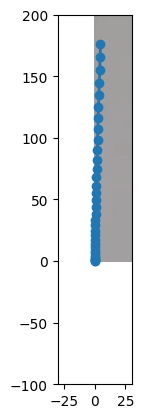

In [149]:
plot_trajectory(comma_future_poses, index=comma_index)

In [150]:
comma_imgs = load_video_images((comma_path / "video.hevc").as_posix())
comma_frame = Image.fromarray(comma_imgs[comma_index][:, :, ::-1])
plt.imshow(np.array(comma_frame))

# Directions in CARLA coordinates
The current problem is that the direction seems to be 180 degrees of what is should be. A turn to the right in the images is plotted as a turn to the left. I want to check if the reason for this is flipped images.

In [151]:
pure_carla_path = Path("./output/pure_carla/carla2k19/Chunk_1/batch1/1/")

In [152]:
pure_carla_positions_np = np.load(carla_path / "global_pose/frame_positions")
pure_carla_orientations_np = np.load(carla_path / "global_pose/frame_orientations")

In [153]:
pure_carla_quats = [euler_to_quat(el[0], el[1], el[2]) for el in pure_carla_orientations_np]

In [154]:
pure_pose = process_pose(pure_carla_positions_np, pure_carla_quats, seq_length)

local_from_ecef = array([[-0.5573 , -0.01662, -0.83014],
       [-0.03103,  0.99952,  0.00082],
       [ 0.82973,  0.02622, -0.55755]])
local_from_ecef = array([[-0.65686, -0.03922, -0.75299],
       [-0.06185,  0.99808,  0.00197],
       [ 0.75147,  0.04786, -0.65802]])
local_from_ecef = array([[-0.74494, -0.06681, -0.66377],
       [-0.09235,  0.99572,  0.00342],
       [ 0.66071,  0.06385, -0.74792]])
local_from_ecef = array([[-0.81998, -0.09826, -0.5639 ],
       [-0.12248,  0.99246,  0.00517],
       [ 0.55914,  0.0733 , -0.82583]])
local_from_ecef = array([[-0.85155, -0.03401, -0.52317],
       [-0.03145,  0.99941, -0.01378],
       [ 0.52333,  0.00471, -0.85212]])
local_from_ecef = array([[-0.84684, -0.01584, -0.53161],
       [ 0.00583,  0.99922, -0.03906],
       [ 0.53181, -0.03618, -0.84609]])
local_from_ecef = array([[-0.84035, -0.01035, -0.54195],
       [ 0.02368,  0.99816, -0.05579],
       [ 0.54153, -0.05972, -0.83856]])
local_from_ecef = array([[-0.83457, -0.00716, -0

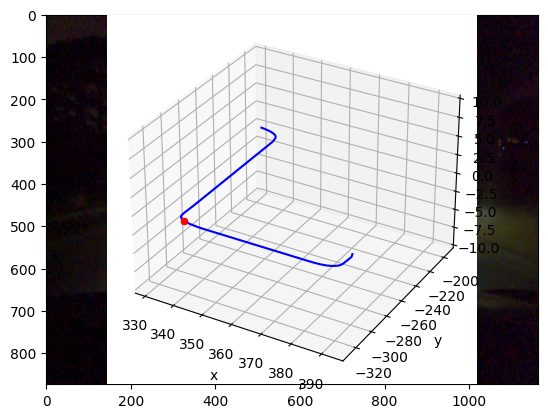

In [155]:
pos = carla_positions_np[2:]
x = [el[0] for el in pos]
# Inverting when plotting
y = [-el[1] for el in pos]
z = [el[2] for el in pos]
ax = plt.axes(projection="3d")
ax.plot3D(x, y, z, "blue")
carla_index = 745
i = carla_index
ax.scatter(x[i], y[i], z[i], color="r")
ax.set_xlabel("x")
ax.set_ylabel("y")
# The z-axis data seems to be quite noisy
ax.set_zlabel("z")
ax.set_zlim(-10, 10)
plt.show()

Here it looks like the car is going left, but from the images it looks like they are going right. Plotting the flipped image to see if it makes sense.

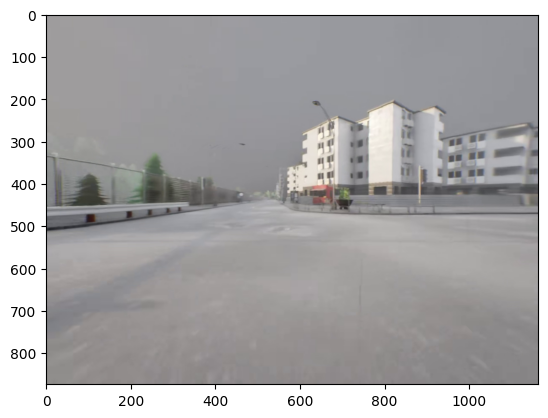

In [156]:
pure_imgs = load_video_images((pure_carla_path / "video.hevc").as_posix())
# FLIPPIN THE IMAGE
pure_frame = Image.fromarray(pure_imgs[carla_index][:, :, ::-1])# .transpose(Image.FLIP_LEFT_RIGHT)
plt.imshow(np.array(pure_frame))
plt.show()

It sort-of makes sense. Is the reason for this flip the inverted y-axis? Will it be wrong to flip the image during saving of the dataset. Need to research this.